# Logistic Regression with L2 regularization

The goal of this assignment is to implement your own logistic regression classifier with L2 regularization. You will do the following:

- Extract features from Amazon product reviews.
- Convert an dataframe into a NumPy array.
- Write a function to compute the derivative of log likelihood function with an L2 penalty with respect to a single coefficient.
- Implement gradient ascent with an L2 penalty.
- Empirically explore how the L2 penalty can ameliorate overfitting.

In [45]:
import pandas as pd
import numpy as np
import string
import json
from __future__ import division
import matplotlib.pyplot as plt
%matplotlib inline

Load and process review dataset

In [46]:
products = pd.read_csv('amazon_baby_subset.csv')

Apply text cleaning on the review data

In [5]:
def remove_punctuation(text):
    return text.translate(None, string.punctuation)

In [47]:
products = products.fillna({'review':''})
products['review_clean'] = products.review.apply(lambda x: remove_punctuation(x))

In [48]:
products.head()

,name,review,rating,sentiment,review_clean
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried nonstop when I tried...
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,We wanted to get something to keep track of ou...
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1,My daughter had her 1st baby over a year ago S...
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1,One of babys first and favorite books and it i...
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1,Very cute interactive book My son loves this b...


In [49]:
with open('important_words.json') as data_file:
    important_words = json.load(data_file)

In [50]:
for word in important_words:
    products[word] = products.review_clean.apply(lambda x: x.split().count(word))

Train-Validation split

In [51]:
with open('module-4-assignment-train-idx.json') as train_data_idx_file:
    train_data_idx = json.load(train_data_idx_file)
train_data = products.iloc[train_data_idx]

In [52]:
with open('module-4-assignment-validation-idx.json') as validation_data_idx_file:
    validation_data_idx = json.load(validation_data_idx_file)
validation_data = products.iloc[validation_data_idx]

Convert data frame to multi-dimensional array

In [56]:
def get_numpy_data(dataframe, features, output):
    dataframe['one'] = 1
    features = ['one'] + features
    feature_dataframe = dataframe[features]
    feature_matrix = feature_dataframe.as_matrix()
    
    output_dataframe = dataframe[output]
    output_matrix = output_dataframe.as_matrix()
    
    return (feature_matrix, output_matrix)

In [57]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment') 

C:\Users\Santosh\Anaconda2\envs\gl-env\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Building on logistic regression with no L2 penalty assignment

In [58]:
def predict_probability(features, coefficients):
    score = np.dot(features, coefficients)
    pred_prob = 1 / (1 + np.exp(-score))
    return (pred_prob)

In [59]:
def feature_derivative_with_L2(feature, error, coefficient, l2_penalty, is_coefficient_const):
    derivative = np.dot(feature, error)
    if not is_coefficient_const:
        derivative = derivative - 2*l2_penalty*coefficient
    return derivative

In [60]:
def compute_log_likelihood_with_l2(features, coefficients, sentiments, l2_penalty):
    indicator = (sentiments == +1)
    score = np.dot(features, coefficients)
    coeff_excl_intercept = coefficients[1:]
    norm2 = np.dot(coeff_excl_intercept, np.transpose(coeff_excl_intercept))
    ll = np.sum((indicator - 1)*score - np.log(1+np.exp(-score))) - l2_penalty*norm2
    return ll

In [61]:
def logistic_regression_with_l2(feature_matrix, sentiments, initial_coefficients, l2_penalty, step_size, max_iter):
    coefficients = np.array(initial_coefficients)
    indicator = (sentiments == +1)
    
    for i in xrange(max_iter):
        pred_prob = predict_probability(feature_matrix, coefficients)
        error = (indicator - pred_prob)
       
        for j in xrange(len(coefficients)):
            partial_derivative = feature_derivative(feature_matrix[:,j], error, coefficients[j], l2_penalty, (j == 0))
            coefficients[j] = coefficients[j] + step_size*partial_derivative

        
    ll = compute_log_likelihood_with_l2(feature_matrix, coefficients, sentiments, l2_penalty)
    print ll

    return coefficients

Explore effects of L2 regularization

In [63]:
feature_matrix = feature_matrix_train
sentiment = sentiment_train
init_coeffs = np.zeros(np.size(feature_matrix, axis=1))
step_size = 5e-6
max_iter = 501
l2_penalty_list = [0, 4, 10, 1e2, 1e3, 1e5]

In [78]:
coefficients_with_l2 = np.zeros([len(l2_penalty_list), 194])
for i in xrange(len(l2_penalty_list)):
    coefficients_with_l2[i] = logistic_regression_with_l2(feature_matrix, sentiment, init_coeffs, l2_penalty_list[i], step_size, max_iter)

-19877.0196926
-19956.5011149
-20072.5379352
-21452.1576365
-25532.6009112
-29271.5217907


Compare coefficients

In [79]:
coefficients_0_penalty = coefficients_with_l2[0]
coeff_0_no_intercept = list(coefficients_0_penalty[1:]) # exclude intercept
word_coefficient_tuples = [(word, coeff_0_no_intercept) for word, coeff_0_no_intercept in zip(important_words, coeff_0_no_intercept)]
word_coefficient_tuples = sorted(word_coefficient_tuples, key=lambda x:x[1], reverse=True)

# Quiz Question. Which of the following is not listed in either positive_words or negative_words?

In [80]:
word_coefficient_tuples[0:5]

[(u'love', 1.0596997836496707),
 (u'loves', 1.0534098221067272),
 (u'easy', 0.98509587876641302),
 (u'perfect', 0.8365276388026418),
 (u'great', 0.80232122759453262)]

In [81]:
word_coefficient_tuples[-6:-1]

[(u'broke', -0.55466734803725326),
 (u'returned', -0.57227874791041922),
 (u'waste', -0.61733291621555997),
 (u'return', -0.74162459742417763),
 (u'money', -0.76797407462045209)]

In [83]:
x_axis = np.log10(l2_penalty_list)
print x_axis

[       -inf  0.60205999  1.          2.          3.          5.        ]


In [85]:
def find_idx(str, important_words):
    i = 0
    for word in important_words:
        if(word == str):
            break
        i = i+1
    return i

In [37]:
def get_coeff_list(coefficients_k_penalty, word_list, important_words):
    coeff_list = np.zeros(len(word_list))
    i = 0
    for word in word_list:
        idx = (find_idx(word, important_words) + 1)
        coeff_list[i] = coefficients_k_penalty[idx]
        i = i + 1
    return coeff_list

In [88]:
# word_list = np.reshape(([[coeff_tuple_0[0:5,0], coeff_tuple_0[-6:-1,0]]]), [10,1])
word_list = ['love', 'easy', 'loves', 'great', 'perfect', 'returned', 'work', 'waste', 'return', 'money']

In [89]:
y_axis = np.zeros([len(l2_penalty_list) ,10])
for i in xrange(len(l2_penalty_list)):
    y_axis[i] = get_coeff_list(coefficients_with_l2[i], word_list, important_words)

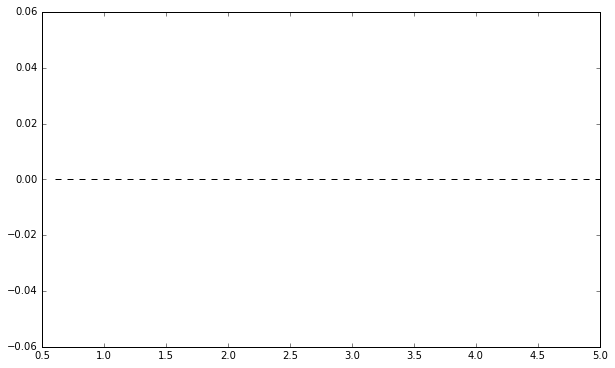

In [90]:
plt.rcParams['figure.figsize'] = 10, 6

cmap_positive = plt.get_cmap('Reds')
cmap_negative = plt.get_cmap('Blues')
    
xx = x_axis
plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')


In [91]:
def predicting_sentiment(feature_matrix, coefficients):
    score = np.dot(feature_matrix, coefficients)
    predictions = np.where(score > 0, 1, -1)
    return (predictions)

In [92]:
def calc_accuracy(products, feature_matrix, coeffs, sentiments):
    predictions = predicting_sentiment(feature_matrix, coeffs)
    num_correctly_classified = np.sum(predictions == sentiments)
    accuracy = (num_correctly_classified / len(products))
    return accuracy

# Which of the following models has the highest accuracy on the training data?

In [93]:
for i in xrange(len(l2_penalty_list)):
    print calc_accuracy(train_data, feature_matrix_train, coefficients_with_l2[i], sentiment_train)

0.785203371025
0.785132551167
0.785061731309
0.783857793725
0.774108259956
0.683057529331


# Which of the following models has the highest accuracy on the validation data?

In [94]:
for i in xrange(len(l2_penalty_list)):
    print calc_accuracy(validation_data, feature_matrix_valid, coefficients_with_l2[i], sentiment_valid)

0.781813089347
0.781813089347
0.781626365419
0.78143964149
0.770703015591
0.670712351788
